In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import spacy
from dateutil import parser
import datetime
from numpy import convolve

from wordcloud import WordCloud, STOPWORDS
from spacy.en import English

# nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
import nltk
from nltk.corpus import stopwords

# gensim
import gensim
from gensim import corpora, models, similarities, matutils
from gensim.utils import lemmatize
from gensim.corpora import Dictionary

# sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

#sentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as vaderSentiment
from textblob import TextBlob

# visualization
import pyLDAvis

# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


%matplotlib inline

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/Pattern-2.6-py3.6.egg/pattern/text/en/../../../../nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
nlp = spacy.load('en')

In [3]:
sns.set_style("whitegrid")

### Import databases

In [4]:
file = open("reviews_rhinoplasty copy.obj",'rb')
reviews_nose = pickle.load(file)
file.close()

In [5]:
new_reviews = []
new_review = {}

for review in reviews_nose:
    for post in review['posts']:
        new_review = {}
        new_review['title'] = review['title']
        new_review['breadcrumbs'] = review['breadcrumbs']
        new_review['username'] = review['username']
        new_review['worthit'] = review['worthit']
        new_review['price'] = review['price']
        new_review['doctor'] = review['doctor']
        new_review['location'] = review['location']
        new_review['procedure_date'] = review['procedure_date']
        
        new_review['post_title'] = post['title']
        new_review['body'] = post['body']
        new_review['likes'] = post['likes']
        new_review['tags'] = post['tags']
        new_review['post_date'] = post['post_date']
        new_review['days_from_procedure'] = post['days_from_procedure']
        
        new_reviews.append(new_review)
        
reviews_date = new_reviews

In [6]:
reviews = pd.DataFrame(reviews_nose)

In [7]:
df = pd.DataFrame(reviews_date)
df['treatment'] = df['breadcrumbs'].apply(lambda x: x[1])

## Clean the Data

In [9]:
#df = df.drop(['breadcrumbs', 'tags'], axis = 1)

In [10]:
def price_clean(price):
    price = price.replace(",", "").replace("$","")
    if price != "":
        return int(price)
    else:
        return 0
    
def worthit_clean(worthit):
    if (worthit != 'Worth It') and (worthit != 'Not Worth It') and (worthit != 'Not Sure'):
        return ''
    else:
        return worthit
    
def format_date(day):
    return parser.parse(day)

def get_year(day):
    return day.year

In [11]:
reviews['worthit'] = reviews['worthit'].apply(worthit_clean)
df['worthit'] = df['worthit'].apply(worthit_clean)
worthit = [reviews[reviews['worthit'] == "Worth It"]['worthit'].count(), reviews[reviews['worthit'] == "Not Worth It"]['worthit'].count(), reviews[reviews['worthit'] == "Not Sure"]['worthit'].count()] 

print("treatment: {}".format(df['treatment'][0]))
print("number of reviews: {}".format(len(reviews)))
print("number of posts: {}".format(len(df)))
print("number of unique users: {}".format(reviews.username.nunique()))
print("number of unique doctors: {}".format(reviews.doctor.nunique()))

treatment: Rhinoplasty
number of reviews: 10901
number of posts: 34508
number of unique users: 10873
number of unique doctors: 2762


In [12]:
df = df[df['procedure_date'] != "None"]
df['post_date'] = df['post_date'].apply(format_date)
df['post_year'] = df['post_date'].apply(get_year)
df_per_year = df.groupby(['post_year']).count()
df_per_year = df_per_year['body'].reset_index()

## Topic Modelling (LDA)

In [13]:
#stop words dictionary
nltk_stopwords = stopwords.words('english')+["did","treatment", "procedure", "I", "done", "nose", "area", "Rhinoplasty", "results", "get", "would", "like", "face", "per","made", "went", "go","still", "little","dont","pron", "i'm", "-PRON-", "rhinoplasty", "job"]

no_features = 1000
no_topics = 5
no_top_words = 30


In [14]:
def get_tokens(text):  
    """Return lemmatized tokens for each review."""
    text = re.sub(r"http\S+", "hyperlink", text) # replace urls with str hyperlink
    letters_only = re.sub("[^a-zA-Z]", " ", text)
    words = ' '.join(letters_only.lower().split())
    try:
        tokens = [token.lemma_ for token in nlp(words)] # get lemmas
    except:
        tokens = [token.lemma_ for token in nlp(words.decode('utf8'))] # get lemmas
    filtered = [t for t in tokens if t != '' and t != ' ' and t != '\n' and t != '\n\n'] # remove any remaining spaces
    filtered = [t for t in filtered if any(letter.isalpha() for letter in t)] # remove numbers without any letters attached
    return ' '.join(filtered)

In [15]:
## Takes 10 min
df['body_lem'] = df['body'].apply(get_tokens)

In [18]:
def print_top_words(model, feature_names, n_top_words = 50):
    """Print top words in each topic."""
    for topic_idx, topic in enumerate(model.components_):
        print ("\nTopic #%d:" % topic_idx)
        print (", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [16]:
# with count vectorizer
def get_topics_lda(df, n_topics):   
    count_vect = CountVectorizer(analyzer = "word",
                                       stop_words = nltk_stopwords,
                                       max_features = 1000, 
                                       max_df = 0.7,
                                       min_df = 5,
                                ngram_range = (1,3))
    matrix = count_vect.fit_transform(df)
    vocab = count_vect.get_feature_names()


    # fit transform lda
    lda = LatentDirichletAllocation(n_components=n_topics,
                learning_method='online', learning_offset=50., max_iter=10,
                random_state=0)
    
    doc_topic_dists = lda.fit_transform(matrix)
    
    # print topic words
    print_top_words(lda, vocab)
    
    # prepare pyLDAvis 
    get_normed = lambda data: pd.DataFrame(data).div(data.sum(axis = 1), axis = 0) 
    prepared = pyLDAvis.prepare(
            doc_lengths = df.str.len(),
            vocab = vocab,
            term_frequency = np.asarray(matrix.sum(axis = 0)).ravel().tolist(),
            topic_term_dists = get_normed(lda.components_), # topics x terms 
            doc_topic_dists = get_normed(doc_topic_dists)) # docs x topics 
    
    return lda, doc_topic_dists, prepared

In [19]:
## Takes 10 min
all_lda, all_doc_topics, all_prepared = get_topics_lda(df['body_lem'], 7)


Topic #0:
surgery, dr, surgeon, consultation, doctor, take, time, ask, say, question, come, day, see, tell, could, also, week, first, office, call, give, book, review, want, work, one, make, appointment, patient, back, meet, consult, schedule, pre, find, wait, hospital, pay, another, need, decide, research, answer, date, explain, feel, photo, email, next, leave

Topic #1:
day, feel, pain, take, sleep, surgery, night, really, wake, good, eye, bad, hour, today, help, much, time, make, start, also, bruise, come, lot, eat, mouth, well, around, keep, home, thing, nurse, think, back, bit, breathe, blood, swell, last, recovery, morning, first, say, use, put, dry, try, pretty, could, cast, able

Topic #2:
dr, surgery, result, look, good, feel, make, happy, want, surgeon, staff, recommend, great, doctor, year, amazing, natural, experience, always, time, comfortable, know, could, plastic, love, work, make feel, care, decision, extremely, even, consultation, take, recovery, well, highly, one, th

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [20]:
pyLDAvis.display(all_prepared)

In [21]:
def get_doc_topics(doc_topic_dist):
    """Return list of topics for documents, given doc topic distribution"""
    return [np.argmax(topic) for doc, topic in enumerate(doc_topic_dist)]

In [22]:
# categorize reviews by most probable topic
df['topic_LDA'] = get_doc_topics(all_doc_topics)

In [23]:
def get_doc_topics_relevant(doc_topic_dist):
    for doc, topic in enumerate(doc_topic_dist):
        if max(topic) > 0.7:
            return (np.argmax(topic))
        else:
            return (-1)
        
topic_LDA_relevant = []
for doc, topic in enumerate(all_doc_topics):
    if max(topic) > 0.7:
        topic_LDA_relevant.append(np.argmax(topic))
    else:
        topic_LDA_relevant.append(-1)
        
# categorize reviews by most probable topic (>0.7)
df['topic_LDA_relevant'] = topic_LDA_relevant

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


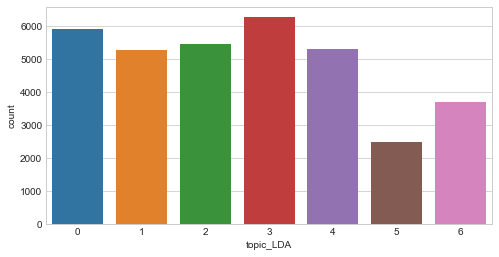

In [24]:
plt.figure(figsize = (8,4))
sns.countplot('topic_LDA', data = df)

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


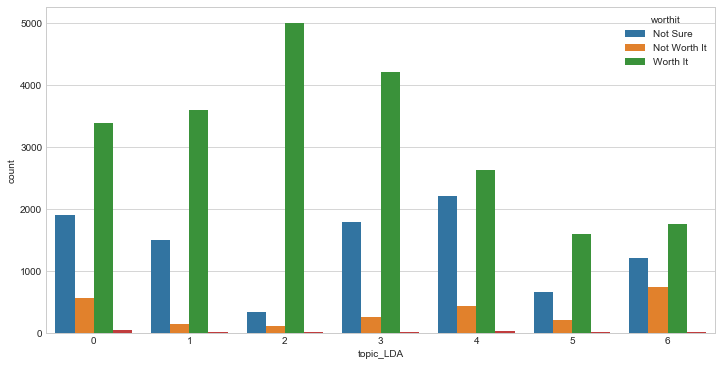

In [25]:
plt.figure(figsize = (12,6))
sns.countplot('topic_LDA', data = df, hue = "worthit")

#### Organize periods

In [26]:
df['days_from_procedure'] = df[df['days_from_procedure'] <= 700]['days_from_procedure']
df['weeks_from_procedure'] = round(df['days_from_procedure'] / 7,0)
df = df[df['weeks_from_procedure'] >0]

In [27]:
## aggregate days by month
def get_months(day):
    if day >= 365:
        return "over 1 year"
    elif day >= 334:
        return "11"
    elif day >= 303:
        return "10"
    elif day >= 272:
        return "11"
    elif day >= 241:
        return "09"
    elif day >= 211:
        return "08"
    elif day >= 181:
        return "07"
    elif day >= 151:
        return "06"
    elif day >= 121:
        return "05"
    elif day >= 91:
        return "04"
    elif day >= 60:
        return "03"
    elif day >= 30:
        return "02"
    else:
        return "01"
    
df['months_from_procedure'] = df['days_from_procedure'].apply(get_months) 

## Sentiment Analysis

In [28]:
def get_sentences(text):
    """Return list of sentences in tweet."""
    sents = sent_tokenize(text)
    return [sent for sent in sents if re.search('[a-zA-Z]', sent) != None]

In [29]:
def get_polarity(sents):
    """Return polarity score for each sentence in text."""
    return [TextBlob(x).sentiment[0] for x in sents]

def get_vader_sentiment(text):
    """Return vaderSentiment score for text."""
    try:
        return vaderSentiment(text)['compound']
    except:
        return 0

In [30]:
df['sentences'] = df['body'].apply(get_sentences)

In [31]:
## Takes 10 min

df['sentiment_scores'] = df['sentences'].apply(get_polarity)

In [32]:
df['avg_sentiment'] = df['sentiment_scores'].apply(np.mean)

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


### Set thresholds for negative and positive

In [33]:
def sentiment_threshold(sentiment):
    if sentiment >= 0.0:
        return "positive"
    elif sentiment <= 0.0:
        return "negative"
    else:
        return "neutral"
    
df['sentiment'] = df['avg_sentiment'].apply(sentiment_threshold)

Text(0.5,1,'Sentiment Distribution')

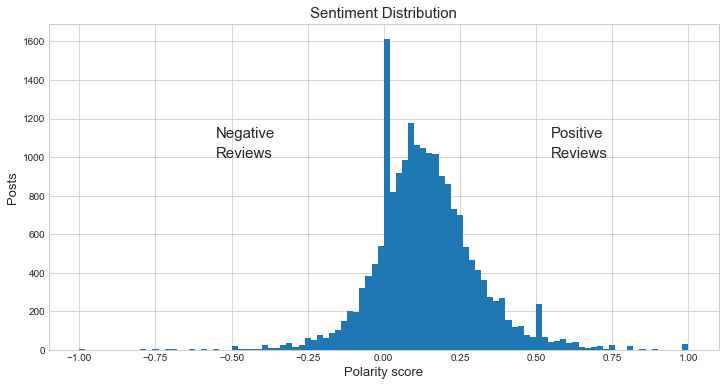

In [34]:
plt.figure(figsize=(12,6))
#sns.plot(df[df['body'] != ""]['avg_sentiment'])
plt.hist(df['avg_sentiment'].dropna(), bins = 100) # ignore NaN's
#plt.axvline(x=-0.01, color="r",linestyle="dashed")
#plt.axvline(x=0.01, color="r",linestyle="dashed")

plt.text(0.55, 1100, "Positive", fontsize=15)
plt.text(0.55, 1000, "Reviews", fontsize=15)
plt.text(-0.55, 1100, "Negative", fontsize=15)
plt.text(-0.55, 1000, "Reviews", fontsize=15)

plt.xlabel("Polarity score", fontsize=13)
plt.ylabel("Posts", fontsize=13)
plt.title("Sentiment Distribution", fontsize=15)

### Topic Ratings

In [35]:
df_topic0 = df[df['topic_LDA'] == 0]
df_topic1 = df[df['topic_LDA'] == 1]
df_topic2 = df[df['topic_LDA'] == 2]
df_topic3 = df[df['topic_LDA'] == 3]
df_topic4 = df[df['topic_LDA'] == 4]
df_topic5 = df[df['topic_LDA'] == 5]
df_topic6 = df[df['topic_LDA'] == 6]

print("topic 0 ocurrences: {}".format(len(df_topic0)))
print("topic 1 ocurrences: {}".format(len(df_topic1)))
print("topic 2 ocurrences: {}".format(len(df_topic2)))
print("topic 3 ocurrences: {}".format(len(df_topic3)))
print("topic 4 ocurrences: {}".format(len(df_topic4)))
print("topic 5 ocurrences: {}".format(len(df_topic5)))
print("topic 6 ocurrences: {}".format(len(df_topic6)))

topic 0 ocurrences: 3508
topic 1 ocurrences: 2771
topic 2 ocurrences: 3779
topic 3 ocurrences: 5280
topic 4 ocurrences: 2419
topic 5 ocurrences: 2047
topic 6 ocurrences: 1886


In [36]:
## Overall Reviews  
perc_positiv_0 = len(df_topic0[df_topic0['sentiment'] == 'positive']['sentiment']) / len(df_topic0.dropna())
print ("Topic 0: {}% of the people review positively". format(round(perc_positiv_0 * 100)))

## Surgery/pos op
perc_positiv_1 = len(df_topic1[df_topic1['sentiment'] == 'positive']['sentiment']) / len(df_topic1.dropna())
print ("Topic 1: {}% of the people review positively". format(round(perc_positiv_1 * 100)))

## Dr/staff
perc_positiv_2 = len(df_topic2[df_topic2['sentiment'] == 'positive']['sentiment']) / len(df_topic2.dropna())
print ("Topic 2: {}% of the people review positively". format(round(perc_positiv_2 * 100)))

## Discomfort(swelling/numb/pain)
perc_positiv_3 = len(df_topic3[df_topic3['sentiment'] == 'positive']['sentiment']) / len(df_topic3.dropna())
print ("Topic 3: {}% of the people review positively". format(round(perc_positiv_3 * 100)))

## Cast Removal/expectations
perc_positiv_4 = len(df_topic4[df_topic4['sentiment'] == 'positive']['sentiment']) / len(df_topic4.dropna())
print ("Topic 4: {}% of the people review positively". format(round(perc_positiv_4 * 100)))

## Updates/photos
perc_positiv_5 = len(df_topic5[df_topic5['sentiment'] == 'positive']['sentiment']) / len(df_topic5.dropna())
print ("Topic 5: {}% of the people review positively". format(round(perc_positiv_5 * 100)))

## Reflecting decision/results
perc_positiv_6 = len(df_topic6[df_topic6['sentiment'] == 'positive']['sentiment']) / len(df_topic6.dropna())
print ("Topic 6: {}% of the people review positively". format(round(perc_positiv_6 * 100)))

Topic 0: 90% of the people review positively
Topic 1: 76% of the people review positively
Topic 2: 98% of the people review positively
Topic 3: 86% of the people review positively
Topic 4: 81% of the people review positively
Topic 5: 84% of the people review positively
Topic 6: 73% of the people review positively


#### Ratings for Categories

In [87]:
Procedure = perc_positiv_1
Recovery = (len(df_topic3[df_topic3['sentiment'] == 'positive']['sentiment']) + len(df_topic4[df_topic4['sentiment'] == 'positive']['sentiment']) + len(df_topic5[df_topic5['sentiment'] == 'positive']['sentiment'])) / (len(df_topic3.dropna()) + len(df_topic4.dropna()) + len(df_topic5.dropna())) 
Results = (len(df_topic0[df_topic0['sentiment'] == 'positive']['sentiment']) + len(df_topic6[df_topic6['sentiment'] == 'positive']['sentiment'])) / (len(df_topic0.dropna()) +  len(df_topic6.dropna()))

print ("Procedure: {}% of the people review positively". format(round(Procedure * 100)))
print ("Recovery: {}% of the people review positively". format(round(Recovery * 100)))
print ("Results: {}% of the people review positively". format(round(Results * 100)))

Procedure: 76% of the people review positively
Recovery: 84% of the people review positively
Results: 80% of the people review positively


In [88]:
import csv
with open('viz/results_nose.csv', 'w') as csvfile:
    csvfile.write('title,rating\n')
    csvfile.write('Procedure,{}\n'.format(Procedure))
    csvfile.write('Recovery,{}\n'.format(Recovery))
    csvfile.write('Results,{}\n'.format(Results))
    csvfile.close()

In [89]:
def label_topic(topic):
    if (topic == 2):
        return 'Procedure'
    elif (topic == 3) or (topic == 4) or (topic == 5):
        return 'Recovery'
    elif (topic == 0) or (topic == 6):
        return 'Result'
    else:
        return 'Recovery'
df['topic_label'] = df['topic_LDA'].apply(label_topic)

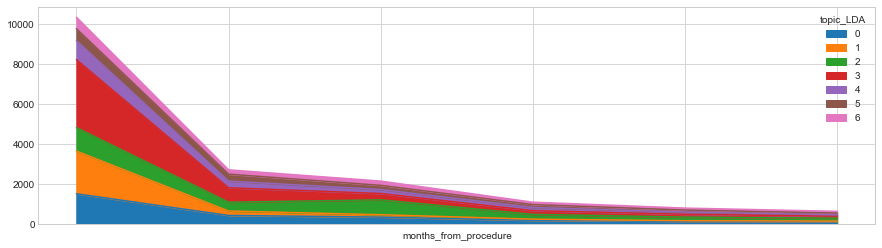

In [90]:
df_period = df.groupby(['months_from_procedure','topic_LDA'])
df_count_posts = df_period.topic_LDA.count()
df_count_posts = df_count_posts.unstack()
df_count_posts[:6].plot.area(figsize=(15,4))

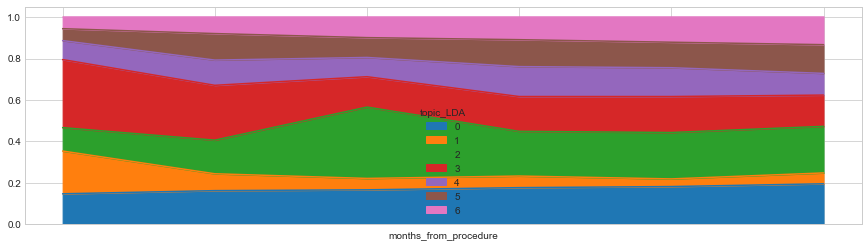

In [91]:
topic_perc = df_count_posts.divide(df_count_posts.sum(axis=1), axis=0)
topic_perc[:6].plot.area(figsize=(15,4))

#### Save DataFrame

In [84]:
pickle.dump(df, open("reviews_topics_nose.pickle",'wb'))
df.to_csv("reviews_topics_nose.csv", encoding='utf-8', index=False)